In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Import genem package
# TODO: discuss the name maybe we can come up with a better name and abbv.
import genem as gn
gn.util.gpu.get_empty_gpu()

Found 1 process(es) running on GPU
Found the following processes: 
GPU ID: 0, PID: 250550, Type: b'C', Pname: b'python', Mem: b'15889MiB'
Empty GPUs: [1]
Assigned GPU 1


# Paths

In [22]:
data_root = '../data/'
log_root = './__logs__/'

# Dataset

../data/2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif


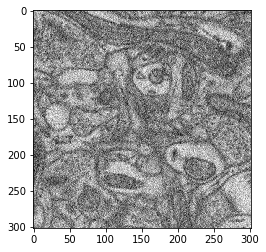

In [23]:
# Let's look at some data
print(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
img = plt.imread(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
plt.imshow(img, cmap='gray');

In [24]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [25]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = np.asarray(plt.imread(os.path.join(self.data_root, self.data_fnames[idx])))
        img = self._normalize(img)
        sample = SBEMCrop2dDataset._reshape_to_torch(img)
        return sample
    
    def _normalize(self, img):
        img = (np.asarray(img)-self.norm_params['mean'])/self.norm_params['std']
        return img
    
    @staticmethod
    def _reshape_to_torch(img):
        sample = torch.from_numpy(np.reshape(img, (1, img.shape[0], img.shape[1]))).float()
        return sample

## Instantiate dataset subclass

In [26]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)
len(sbem_dataset)

60

## Test dataset subclass

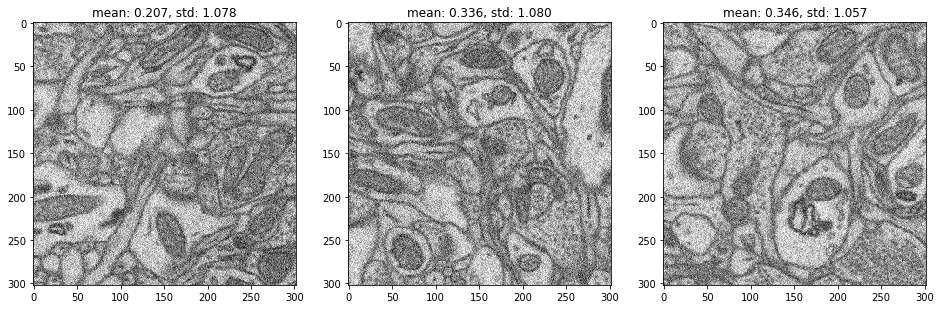

In [27]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    sample = sbem_dataset[i]
    img = sample.data.numpy().squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

In [28]:
img.dtype

dtype('float32')

# Model

## Define Model

In [29]:
def get_conv_pad(input_size, kernel_size, stride):
    padding = np.ceil(((stride-1)*input_size-stride+kernel_size)/2).astype(int)
    return padding

In [30]:
class Encoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*4, n_fmaps*8, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(17**2*n_fmaps*8, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_conv4(x)
        x = self.encoding_fc(x.reshape((-1, 1, 17**2*n_fmaps*8)))
        
        return x

In [31]:
class Decoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, output_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.decoding_fc = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 17**2*n_fmaps*8),
            torch.nn.ReLU())
        
        self.decoding_convt1 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*8, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU())
        
        self.decoding_convt2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*4, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU())

        self.decoding_convt3 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*2, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU())
        
        self.decoding_convt4 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps, 1, kernel_size, stride),
            torch.nn.Tanh())
        
    def forward(self, x):
        
        x = self.decoding_fc(x)
        x = self.decoding_convt1(x.reshape((-1, n_fmaps*8, 17, 17)))
        x = self.decoding_convt2(x)
        x = self.decoding_convt3(x)
        x = self.decoding_convt4(x)
        
        return x

In [32]:
class AE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Instantiate Model, Loss and Optimizer

In [33]:
input_size=302
output_size=input_size
kernel_size=3
stride=1
n_fmaps=8
n_latent=5000
net = AE(
    Encoder_4_sampling_bn(input_size, kernel_size, stride, n_fmaps, n_latent), 
    Decoder_4_sampling_bn(output_size, kernel_size, stride, n_fmaps, n_latent))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
# device name
dev = torch.device('cuda:1');

## Utility functions

In [34]:
def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    input_cpu = inputs[idx].data.cpu()
    img_input = input_cpu.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    output_cpu = outputs[idx].data.cpu()
    img_output = output_cpu.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

# Train Model

In [49]:
trainloader = DataLoader(sbem_dataset, batch_size=10, shuffle=True, num_workers=2)
writer = SummaryWriter(log_root)
writer_int = 10
n_epoch = 50000
it = 0
net = net.cuda();
for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        it += 1

        inputs = data
        inputs = inputs.cuda();
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        if((i+1) % 5) == 0:

            avg_loss = running_loss / writer_int

            print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(it, epoch, i+1, avg_loss))

            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('avg_loss', avg_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)

            running_loss = 0.0

it: 5 (epoch: 0, batch: 5), running loss: 0.283
it: 65 (epoch: 10, batch: 5), running loss: 0.283
it: 125 (epoch: 20, batch: 5), running loss: 0.283
it: 185 (epoch: 30, batch: 5), running loss: 0.284
it: 245 (epoch: 40, batch: 5), running loss: 0.283
it: 305 (epoch: 50, batch: 5), running loss: 0.283
it: 365 (epoch: 60, batch: 5), running loss: 0.284
it: 425 (epoch: 70, batch: 5), running loss: 0.284
it: 485 (epoch: 80, batch: 5), running loss: 0.284
it: 545 (epoch: 90, batch: 5), running loss: 0.283
it: 605 (epoch: 100, batch: 5), running loss: 0.283
it: 665 (epoch: 110, batch: 5), running loss: 0.285
it: 725 (epoch: 120, batch: 5), running loss: 0.283
it: 785 (epoch: 130, batch: 5), running loss: 0.282
it: 845 (epoch: 140, batch: 5), running loss: 0.282
it: 905 (epoch: 150, batch: 5), running loss: 0.281
it: 965 (epoch: 160, batch: 5), running loss: 0.282
it: 1025 (epoch: 170, batch: 5), running loss: 0.282
it: 1085 (epoch: 180, batch: 5), running loss: 0.283
it: 1145 (epoch: 190, ba

KeyboardInterrupt: 

In [45]:
print(trainloader.batch_size)

10


In [29]:
modelPath = os.path.join(log_root,'50KEpoch_v1.pt')
torch.save(net,modelPath)

/u/alik/conda-envs/gen-EM/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/u/alik/conda-envs/gen-EM/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Encoder_3_sampling. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/u/alik/conda-envs/gen-EM/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Decoder_3_sampling. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


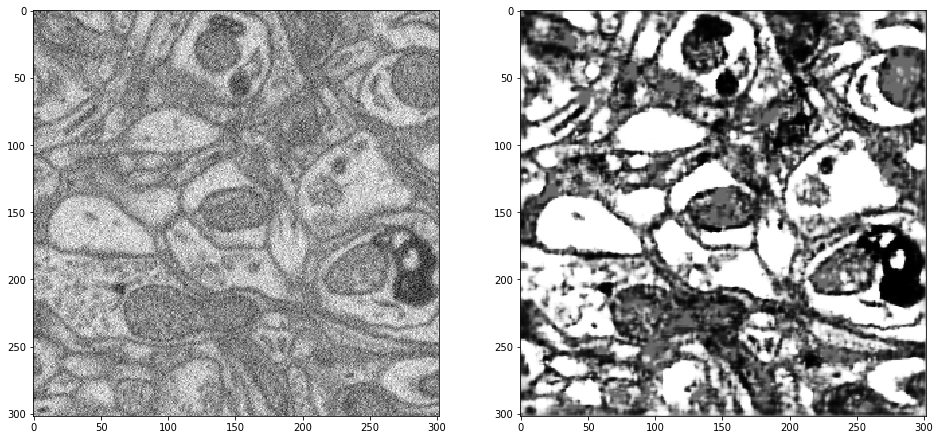

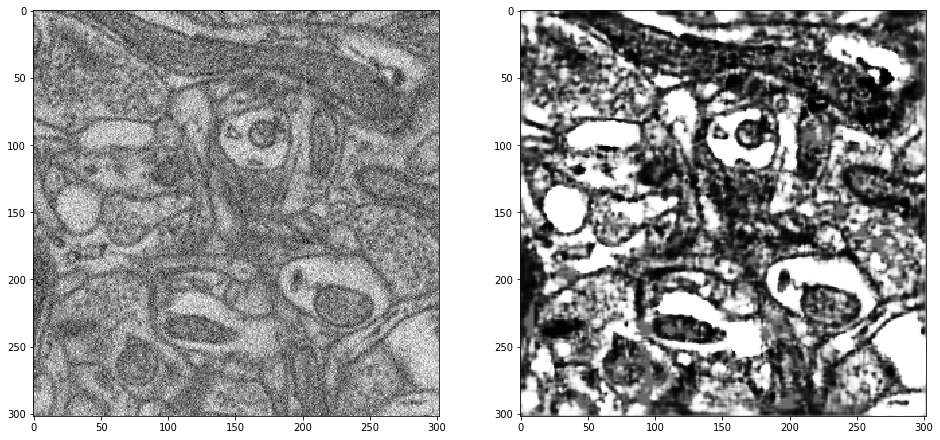

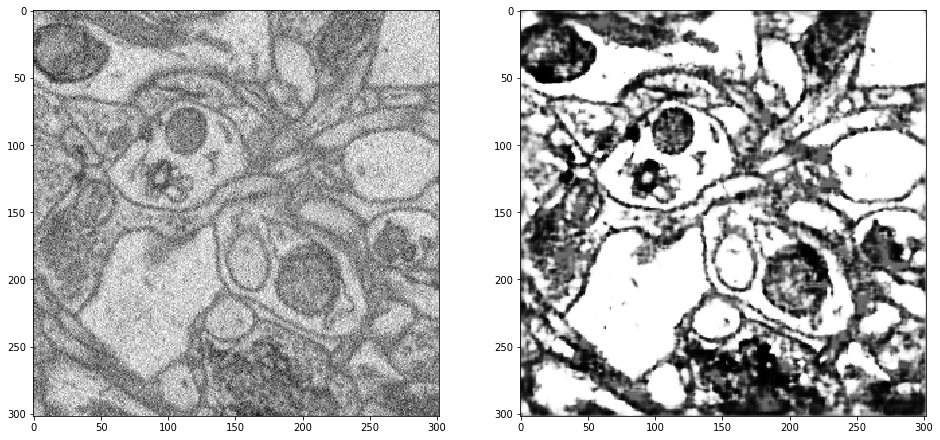

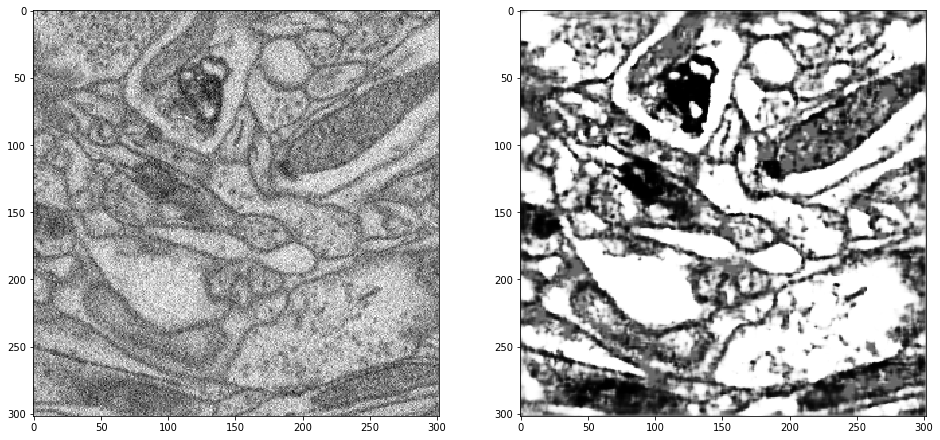

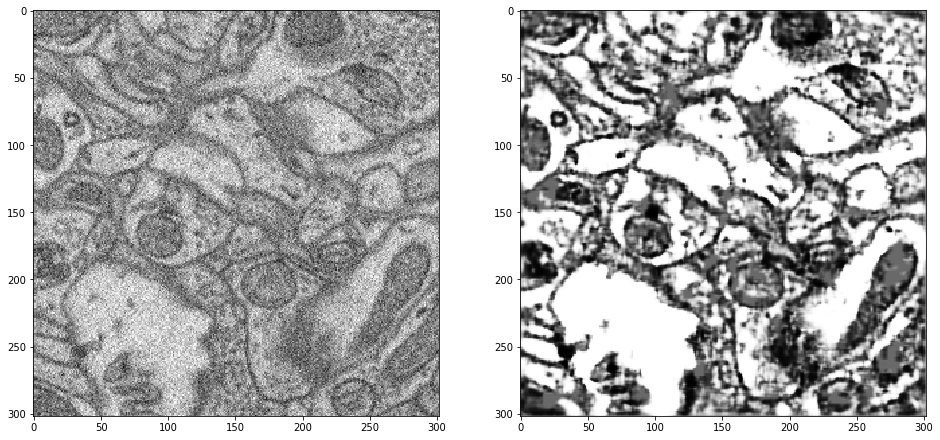

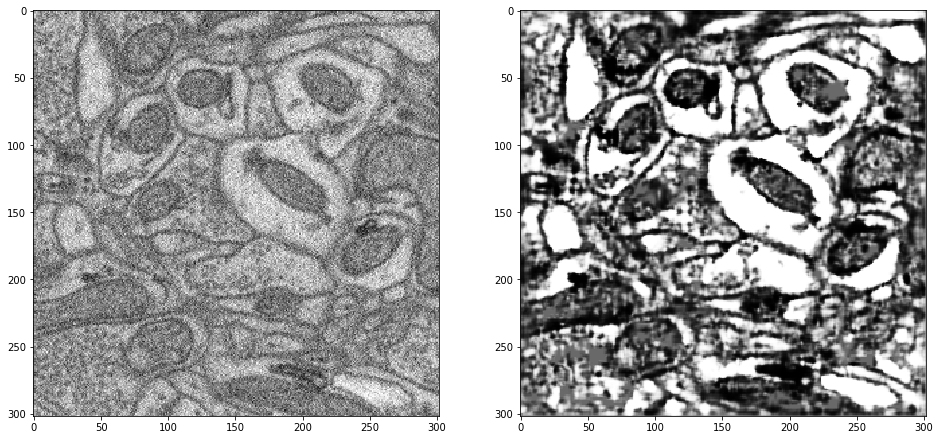

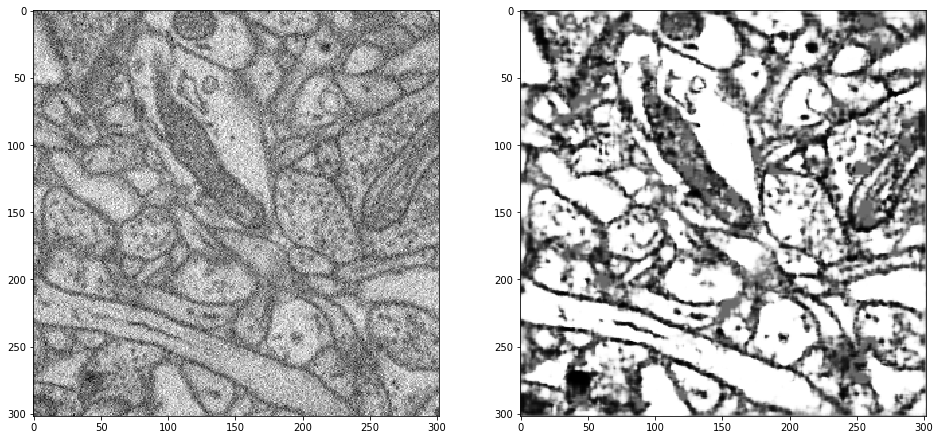

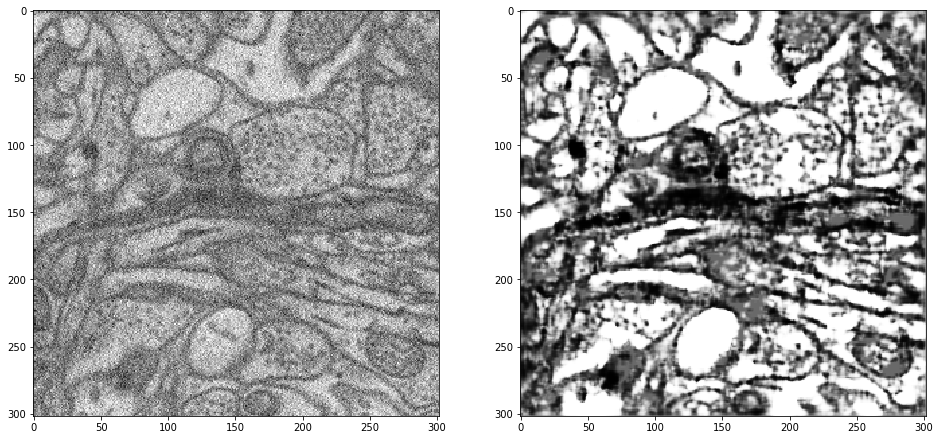

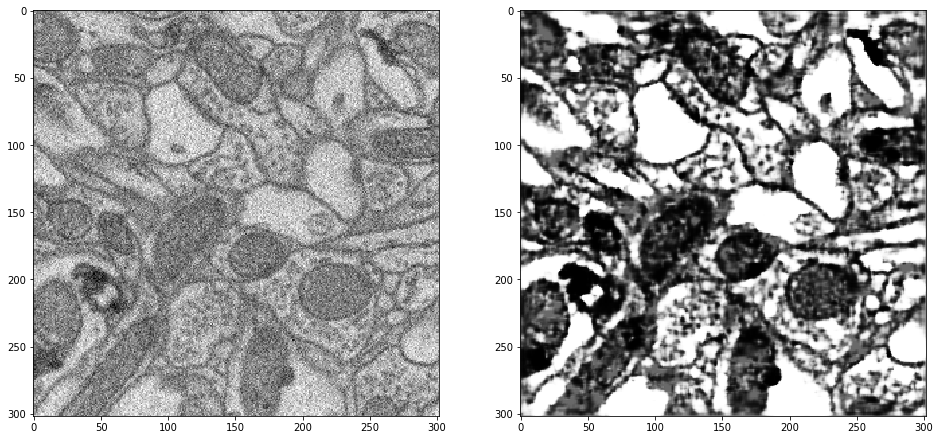

In [50]:
# Show input vs output
for i in range(1,10,1):
    data2fig_subplot(inputs, outputs, i);


(array([ 7606.,  5916.,  6579.,  6383.,  6513.,  8258., 13670.,  2499.,
         2386., 31394.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

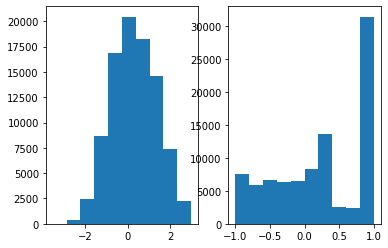

In [31]:
fig, axs = plt.subplots(1,2)
axs[0].hist(inputs[0].data.cpu().numpy().flatten())
axs[1].hist(outputs[0].data.cpu().numpy().flatten())